In [1]:
from folktables import ACSDataSource, ACSEmployment, generate_categories
import math



data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
definition_df = data_source.get_definitions(download=True)
acs_data = data_source.get_data(states=["AL"], download=True)
features_unscaled, label, group = ACSEmployment.df_to_pandas(acs_data)
categories = generate_categories(features=features_unscaled, definition_df=definition_df)

In [2]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = StandardScaler()
scaler = MinMaxScaler()
features = features_unscaled.copy()
features[features.columns] = scaler.fit_transform(features[features.columns])
features

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P
0,0.204301,0.750000,1.0,1.000000,1.0,0.000,0.0,1.000000,1.0,0.000000,0.0,1.0,1.0,1.0,1.0,0.000
1,0.193548,0.750000,1.0,1.000000,1.0,0.000,0.0,1.000000,1.0,0.000000,0.0,1.0,1.0,1.0,1.0,0.125
2,0.569892,0.708333,1.0,0.941176,0.0,0.000,0.0,0.333333,1.0,0.333333,0.0,1.0,1.0,0.5,0.0,0.000
3,0.301075,0.791667,1.0,0.941176,1.0,0.000,0.0,0.333333,0.5,0.000000,0.0,1.0,1.0,1.0,0.0,0.000
4,0.268817,0.500000,1.0,0.941176,0.0,0.000,0.0,1.000000,1.0,0.000000,0.0,1.0,1.0,0.5,1.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47772,0.193548,0.666667,1.0,0.117647,1.0,0.000,0.0,0.333333,1.0,0.000000,0.0,1.0,1.0,1.0,1.0,0.000
47773,0.161290,0.458333,1.0,0.117647,1.0,0.875,0.0,0.333333,0.0,0.000000,0.0,1.0,1.0,1.0,0.0,0.000
47774,0.107527,0.250000,1.0,0.117647,1.0,0.875,0.0,0.333333,0.0,0.000000,0.0,1.0,1.0,1.0,0.0,0.000
47775,0.043011,0.041667,1.0,0.117647,1.0,0.875,0.0,0.333333,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,0.000


In [3]:
# mapping categories from unscaled to scaled
assert isinstance(scaler, MinMaxScaler)
categories_scaled = {}

for column in categories:
    categories_scaled[column] = {}
    idx = list(features_unscaled.columns).index(column)
    for key in categories[column].keys():
        if(not math.isnan(key)):
            categories_scaled[column][key * scaler.scale_[idx] + scaler.min_[idx]] = categories[column][key]

In [4]:
categories_scaled['DREM']

{0.5: 'Yes', 1.0: 'No'}

In [5]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

###### Your favorite learning algorithm here #####
model = LogisticRegression()
model.fit(X_train, y_train)
yhat = model.predict(X_test)

/Users/bishwamittraghosh/mambaforge-pypy3/envs/fairness_tutorial/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:
for column in features.columns:
    if(column not in categories_scaled): # not a categorical feature
        continue

    
    prediction_probs = {}
    for val in categories_scaled[column]:
        prediction_probs[val] = np.mean(yhat[(y_test.values == 1).ravel() & (X_test[column].values == val)])

    min_val = min(prediction_probs, key=prediction_probs.get)
    max_val = max(prediction_probs, key=prediction_probs.get)

    print(column)
    print(categories_scaled[column][max_val], "vs", categories_scaled[column][min_val])
    print("Disparity:", prediction_probs[max_val] - prediction_probs[min_val])
    print()

SCHL
Doctorate degree vs Nursery school, preschool
Disparity: 0.9811320754716981

MAR
Married vs Widowed
Disparity: 0.42253886010362696

RELP
Stepson or stepdaughter vs Parent-in-law
Disparity: 0.84375

DIS
Without a disability vs With a disability
Disparity: 0.6273053903539045

ESP
Both parents in labor force vs Father only in labor force
Disparity: 0.5217391304347826

CIT
Born abroad of American parent(s) vs Born in Puerto Rico, Guam, the U.S. Virgin Islands, or the Northern Marianas
Disparity: 0.24637681159420288

MIG
Yes, same house (nonmovers) vs No, outside US and Puerto Rico
Disparity: 0.15579688875843856

MIL
Now on active duty vs Now on active duty
Disparity: nan

ANC
Unclassified vs Not reported
Disparity: 0.05544337876493355

NATIVITY
Foreign born vs Native
Disparity: 0.005527331689150983

DEAR
No vs Yes
Disparity: 0.5187472604325192

DEYE
No vs Yes
Disparity: 0.47656048282984764

DREM
No vs Yes
Disparity: 0.7000834392879848

SEX
Male vs Female
Disparity: 0.10777651592724302

/Users/bishwamittraghosh/mambaforge-pypy3/envs/fairness_tutorial/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/bishwamittraghosh/mambaforge-pypy3/envs/fairness_tutorial/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
from justicia.metrics import Metric

justicia_results = []

for sensitive_feature_set in [['SEX'], ['DIS'], ['SEX', 'DIS']]:

    print("Sensitive features", sensitive_feature_set)
    metric = Metric(model=model, 
                    data=X_test, 
                    sensitive_attributes=sensitive_feature_set, 
                    verbose=False, 
                    encoding="best-correlated",
                    dag_threshold=0.2)
    metric.compute()
    print("Sensitive attributes", metric.given_sensitive_attributes)
    print("Disparate Impact:", metric.disparate_impact_ratio)
    print("Statistical Parity:", metric.statistical_parity_difference)
    print("Time taken", metric.time_taken, "seconds")
    print(metric)
    print()
    justicia_results.append(metric)
    



/Users/bishwamittraghosh/mambaforge-pypy3/envs/fairness_tutorial/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sensitive features ['SEX']
Sensitive attributes ['SEX']
Disparate Impact: 0.7998327988213291
Statistical Parity: 0.09093182500752145
Time taken 92.00306582450867 seconds

Justicia
 - encoding: Learn-efficient-dependency
 - model: LogisticRegression()
 - given_sensitive_attributes: ['SEX']
 - sensitive_group_statistics: [([('SEX', ('!=', 1.0))], 0.4542793448281017, 71, 20), ([('SEX', ('==', 1.0))], 0.3633475198205803, 71, 20)]
 - given_mediator_attributes: []
 - given_major_group: {}
 - time_taken: 92.00306582450867
 - most_favored_group: {'SEX': ('!=', 1.0)}
 - least_favored_group: {'SEX': ('==', 1.0)}
 - statistical_parity_difference: 0.09093182500752145
 - disparate_impact_ratio: 0.7998327988213291

Sensitive features ['DIS']
Sensitive attributes ['DIS']
Disparate Impact: 0.6754887957838005
Statistical Parity: 0.14066973324202742
Time taken 92.13065814971924 seconds

Justicia
 - encoding: Learn-efficient-dependency
 - model: LogisticRegression()
 - given_sensitive_attributes: ['DIS']

In [8]:
categories_scaled['SEX'], categories_scaled['DIS']

({0.0: 'Male', 1.0: 'Female'},
 {0.0: 'With a disability', 1.0: 'Without a disability'})

In [9]:
encoded_df_train = X_train.copy()
encoded_df_train['target'] = y_train

encoded_df_test = X_test.copy()
encoded_df_test['target'] = y_test

In [10]:
import aif360
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.preprocessing.reweighing import Reweighing


binary_label_dataset_train = aif360.datasets.BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=encoded_df_train,
    label_names=['target'],
    protected_attribute_names=['SEX'])
binary_label_dataset_test = aif360.datasets.BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=encoded_df_test,
    label_names=['target'],
    protected_attribute_names=['SEX'])


if(False):
    # Disparate Impact Remover
    di = DisparateImpactRemover(repair_level = 1.0)
    di.fit(binary_label_dataset_train)

    dataset_transf_train = di.fit_transform(binary_label_dataset_train).convert_to_dataframe()[0]
    dataset_transf_test = di.fit_transform(binary_label_dataset_test).convert_to_dataframe()[0]


else:
    # Reweighing
    rw = Reweighing(unprivileged_groups=[{'SEX' : 1}], privileged_groups=[{'SEX' : 0}])
    rw.fit(binary_label_dataset_train)

    binary_label_dataset_trans_train = rw.transform(binary_label_dataset_train)
    dataset_transf_train = binary_label_dataset_trans_train.convert_to_dataframe()[0]
    dataset_transf_test = rw.transform(binary_label_dataset_test).convert_to_dataframe()[0]

X_trans_train = dataset_transf_train.drop(['target'], axis = 1)
y_trans_train = dataset_transf_train['target']


X_trans_test = dataset_transf_test.drop(['target'], axis = 1)
y_trans_test = dataset_transf_test['target']



pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


In [11]:
model_trans = LogisticRegression()
model_trans.fit(X_trans_train, y_trans_train, sample_weight= binary_label_dataset_trans_train.instance_weights)

LogisticRegression()

In [12]:
from justicia.metrics import Metric
metric_trans = Metric(model=model_trans, 
                data=X_trans_test, 
                sensitive_attributes=['SEX'], 
                verbose=False, 
                encoding="best-correlated",
                dag_threshold=0.2)
metric.compute()
print("Sensitive attributes", metric_trans.given_sensitive_attributes)
print("Disparate Impact:", metric_trans.disparate_impact_ratio)
print("Statistical Parity:", metric_trans.statistical_parity_difference)
print("Time taken", metric_trans.time_taken, "seconds")
metric_trans

Sensitive attributes ['SEX']
Disparate Impact: 0.9055444497433087
Statistical Parity: 0.0403400387924055
Time taken 72.39568519592285 seconds



Justicia
 - encoding: Learn-efficient-dependency
 - model: LogisticRegression()
 - given_sensitive_attributes: ['SEX']
 - sensitive_group_statistics: [([('SEX', ('!=', 1.0))], 0.42707960181035304, 75, 10), ([('SEX', ('==', 1.0))], 0.38673956301794754, 75, 10)]
 - given_mediator_attributes: []
 - given_major_group: {}
 - time_taken: 72.39568519592285
 - most_favored_group: {'SEX': ('!=', 1.0)}
 - least_favored_group: {'SEX': ('==', 1.0)}
 - statistical_parity_difference: 0.0403400387924055
 - disparate_impact_ratio: 0.9055444497433087

In [13]:
from fairxplainer.fair_explainer import FairXplainer
from fairxplainer.fair_explainer import plot as fif_plot
from fairxplainer import utils

fairXplainer = FairXplainer(model_trans, X_trans_test, ['SEX'])
fairXplainer.compute(maxorder=2, spline_intervals=3, verbose=True, cpu_time=800)




c Decomposition for  SEX = 1.0
c positive prediction probability of  SEX = 1.0 is 0.4118715929739552
c sample shape: (4953, 16)
c sensitive group: SEX = 1.0
c variance of Y 0.2422333838750518
c mean of Y 0.4118715929739552





c Decomposition for  SEX = 0.0
c positive prediction probability of  SEX = 0.0 is 0.44253747555941775
c sample shape: (4603, 16)
c sensitive group: SEX = 0.0
c variance of Y 0.2466980582849155
c mean of Y 0.44253747555941775


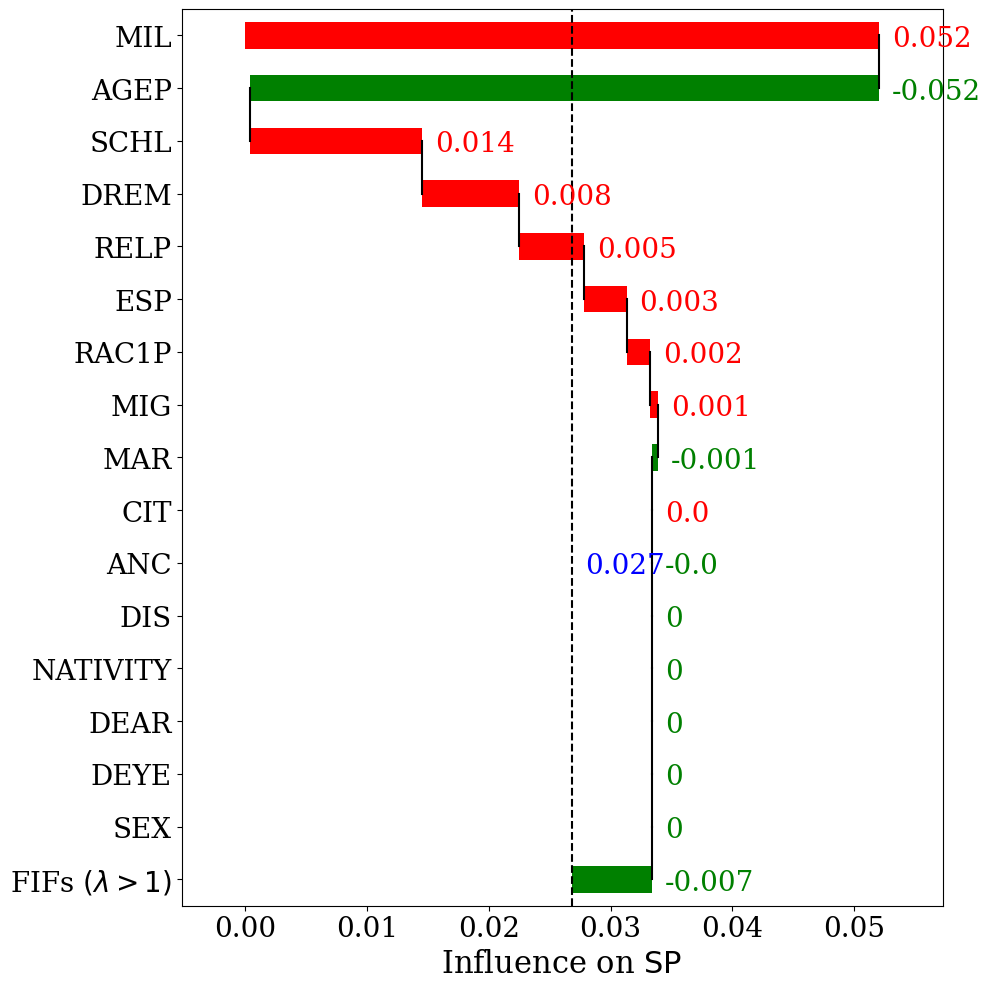

Exact statistical parity 0.030665882585462545


<Figure size 1000x1000 with 0 Axes>

In [14]:
result = fairXplainer.get_weights()

fontsize = 22
labelsize = 20

plt = fif_plot(result, 
                draw_waterfall=True, 
                labelsize=labelsize, 
                figure_size=(10,10), 
                text_y_pad=0.2, 
                xlim=None, 
                result_y_location=0.6,
                x_label="Influence on " + r"$ \mathsf{SP} $"
            )
plt.show()
plt.clf()
print("Exact statistical parity", fairXplainer.statistical_parity_sample())

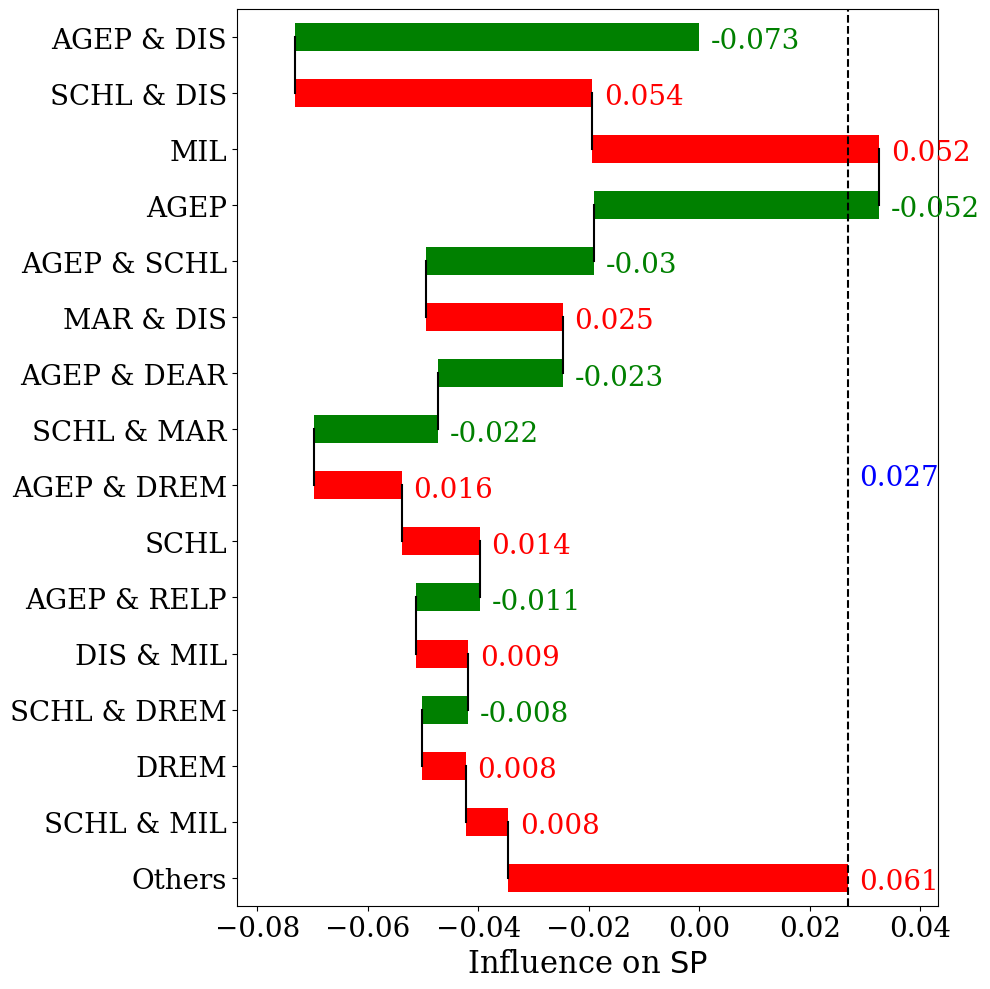

Exact statistical parity 0.030665882585462545


<Figure size 1000x1000 with 0 Axes>

In [15]:
k = 15
result = fairXplainer.get_top_k_weights(k=k)

plt = fif_plot(result, 
               draw_waterfall=True, 
               labelsize=labelsize, 
               figure_size=(10,10), 
               text_y_pad=0.2, 
               xlim=None, 
               result_x_pad=0.02,
               x_label="Influence on " + r"$ \mathsf{SP} $"
        )
plt.tight_layout()
plt.show()
plt.clf()

print("Exact statistical parity", fairXplainer.statistical_parity_sample())

In [26]:
def good_name(result):
    result = result.copy()
    good_name_features = {
        'AGEP' : 'Age',
        'SCHL' : 'Education',
        'MAR' : 'Marital status',
        'RELP' : 'Relationship',
        'DIS' : 'Disability',
        'ESP' : "Parent's employment",
        'CIT' : 'Citizenship',
        'MIG' : 'Mobility status',
        'MIL' : 'Military service',
        'ANC' : 'Ancestry',
        'NATIVITY' : 'Nativity',
        'DEAR' : 'Hearing difficulty',
        'DEYE' : 'Vision difficulty',
        'DREM' : 'Cognitive difficulty',
        'SEX' : 'Sex',
        'RAC1P' : 'Race'
    }
    good_name_index = []
    for feature_combination in result.index:
        feature_combination_revised = []
        for i, feature in enumerate(feature_combination.split(" & ")):
            feature_combination_revised.append(good_name_features[feature] if feature in good_name_features else feature)
        good_name_index.append(" & ".join(feature_combination_revised))
    print(good_name_index)

    result.index = good_name_index
    return result

['Age & Disability', 'Education & Disability', 'Military service', 'Age', 'Age & Education', 'Marital status & Disability', 'Age & Hearing difficulty', 'Education & Marital status', 'Age & Cognitive difficulty', 'Education', 'Age & Relationship', 'Disability & Military service', 'Education & Cognitive difficulty', 'Cognitive difficulty', 'Education & Military service', 'Others']


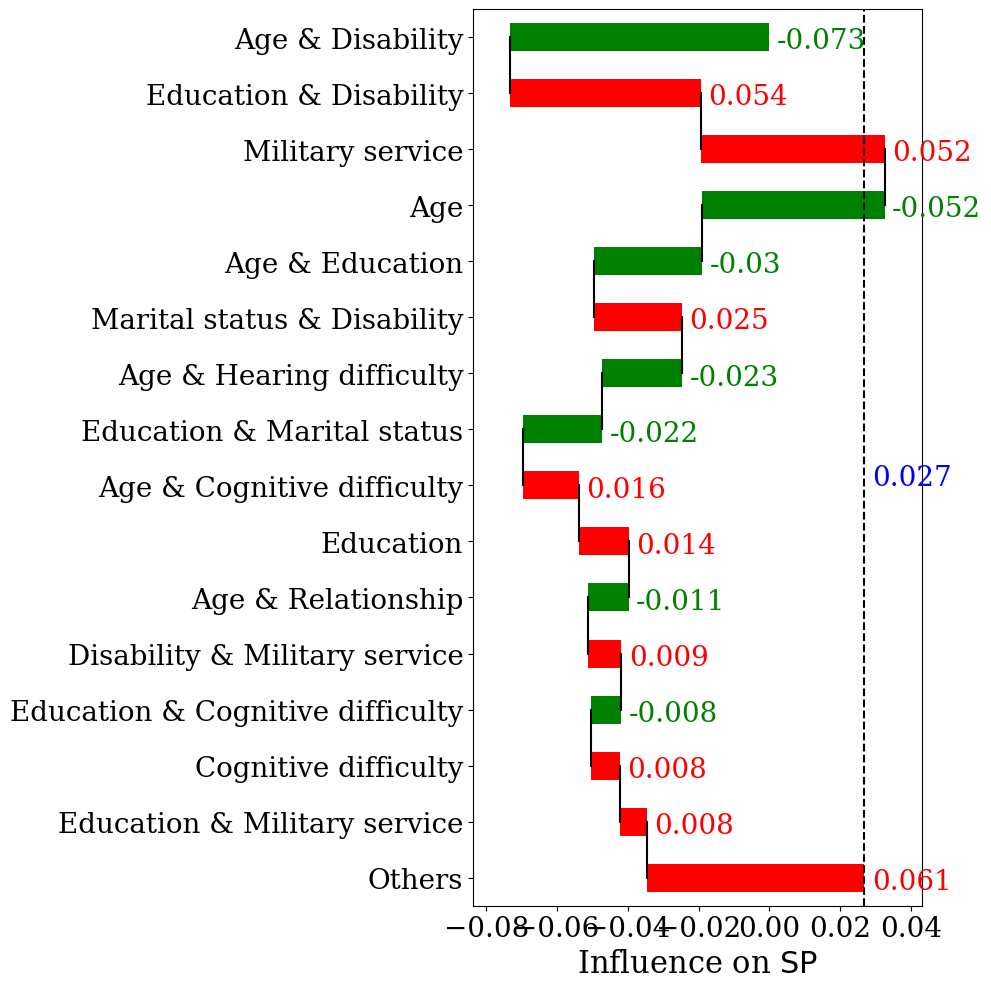

Exact statistical parity 0.030665882585462545


<Figure size 1000x1000 with 0 Axes>

In [27]:
plt = fif_plot(good_name(result), 
               draw_waterfall=True, 
               labelsize=labelsize, 
               figure_size=(10,10), 
               text_y_pad=0.2, 
               xlim=None, 
               result_x_pad=0.02,
               x_label="Influence on " + r"$ \mathsf{SP} $"
        )
plt.tight_layout()
plt.show()
plt.clf()

print("Exact statistical parity", fairXplainer.statistical_parity_sample())